In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.linalg import solve

### Задача Дирихле

In [2]:
# --- 1. Задача Дирихле ---
def tridiagonal_solver(a, b, c, d):
    n = len(d)
    alpha = np.zeros(n)
    beta = np.zeros(n)
    y = np.zeros(n)
    alpha[0] = -c[0] / b[0]
    beta[0] = d[0] / b[0]
    for i in range(1, n):
        denominator = b[i] + a[i] * alpha[i - 1]
        alpha[i] = -c[i] / denominator
        beta[i] = (d[i] - a[i] * beta[i - 1]) / denominator
    y[n - 1] = beta[n - 1]
    for i in range(n - 2, -1, -1):
        y[i] = alpha[i] * y[i + 1] + beta[i]
    return y


def solve_dirichlet_fdm(n_points):
    x_start, x_end = 0, 1
    h = (x_end - x_start) / (n_points - 1)
    x = np.linspace(x_start, x_end, n_points)
    a = np.zeros(n_points)
    b = np.zeros(n_points)
    c = np.zeros(n_points)
    d = np.zeros(n_points)
    y_fd = np.zeros(n_points)
    for i in range(1, n_points - 1):
        xi = x[i]
        a[i] = 1 - (h * xi) / 2
        b[i] = -2 - 2 * h ** 2
        c[i] = 1 + (h * xi) / 2
        d[i] = 2 * h ** 2
    b[0] = 1
    d[0] = 0
    b[n_points - 1] = 1
    d[n_points - 1] = 1
    y_fd = tridiagonal_solver(a, b, c, d)
    return x, y_fd

### Краевая задача (метод конечных разностей)

In [3]:
def solve_boundary_fdm(n_points):
    x_start, x_end = 0.6, 0.9
    h = (x_end - x_start) / (n_points - 1)
    x = np.linspace(x_start, x_end, n_points)
    a = np.zeros(n_points)
    b = np.zeros(n_points)
    c = np.zeros(n_points)
    d = np.zeros(n_points)
    y_fd = np.zeros(n_points)
    for i in range(1, n_points - 1):
        xi = x[i]
        a[i] = 1 - h
        b[i] = -2 - h ** 2 * xi
        c[i] = 1 + h
        d[i] = h ** 2 * xi ** 2
    a[0] = 0
    b[0] = -1
    c[0] = 1
    d[0] = 0.7 * h
    a[n_points - 1] = -0.5 / h
    b[n_points - 1] = 1 + 0.5 / h
    c[n_points - 1] = 0
    d[n_points - 1] = 1
    y_fd = tridiagonal_solver(a, b, c, d)
    return x, y_fd

### Краевая задача метод Галеркина

In [4]:
def solve_boundary_galerkin_strict_lifting(n=2):  # Определяет функцию solve_boundary_galerkin_strict_lifting.
    a_val = 0.6  # Левая граница.
    b_val = 0.9  # Правая граница.

    # --- Построение подъемной функции yp(x) ---
    def yp(x):
        return 0.72 + 0.7 * x  # Определяет подъемную функцию yp(x).

    def dyp_dx(x):
        return 0.7 + 0 * x  # Определяет первую производную подъемной функции.

    def ddyp_dx2(x):
        return 0 + 0 * x  # Определяет вторую производную подъемной функции.

    # --- Построение базисных функций psi_i(x) для однородной задачи ---
    def psi0(x):
        return 0.57 - 1.2 * x + x ** 2  # Определяет базисную функцию psi0(x).

    def psi1(x):
        return 0.918 - 1.08 * x + x ** 3  # Определяет базисную функцию psi1(x).

    def dpsi0_dx(x):
        return -1.2 + 2 * x  # Определяет первую производную psi0(x).

    def dpsi1_dx(x):
        return -1.08 + 3 * x ** 2  # Определяет первую производную psi1(x).

    def ddpsi0_dx2(x):
        return 2 + 0 * x  # Определяет вторую производную psi0(x).

    def ddpsi1_dx2(x):
        return 6 * x  # Определяет вторую производную psi1(x).

    def residual_integrand(x, c0, c1,
                           psi_i):  # Определяет функцию для вычисления подынтегрального выражения для невязки.
        yh = yp(x) + c0 * psi0(x) + c1 * psi1(x)  # Вычисляет приближенное решение yh(x).
        dyh_dx = dyp_dx(x) + c0 * dpsi0_dx(x) + c1 * dpsi1_dx(x)  # Вычисляет первую производную yh(x).
        ddyh_dx2 = ddyp_dx2(x) + c0 * ddpsi0_dx2(x) + c1 * ddpsi1_dx2(x)  # Вычисляет вторую производную yh(x).
        R = ddyh_dx2 + 2 * dyh_dx - x * yh - x ** 2  # Вычисляет невязку R.
        return R * psi_i(x)  # Возвращает подынтегральное выражение.

    A = np.zeros((2, 2))  # Создает матрицу A размером 2x2 для системы уравнений Галеркина.
    b_vec = np.zeros(2)  # Создает вектор b_vec длиной 2 для системы уравнений Галеркина.

    for i in range(2):  # Цикл по базисным функциям.
        psi_i = [psi0, psi1][i]  # Выбирает текущую базисную функцию.
        for j in range(2):  # Цикл по базисным функциям для вычисления элементов матрицы A.
            psi_j = [psi0, psi1][j]  # Выбирает базисную функцию для вычисления элемента A[i, j].

            def integrand_A(x, j_val):  # Определяет функцию для вычисления подынтегрального выражения для A[i, j].
                d2psi_j_dx2 = [ddpsi0_dx2, ddpsi1_dx2][j_val](x)
                dpsi_j_dx = [dpsi0_dx, dpsi1_dx][j_val](x)
                psi_j_val = [psi0, psi1][j_val](x)
                return (d2psi_j_dx2 + 2 * dpsi_j_dx - x * psi_j_val) * psi_i(x)

            A[i, j] = quad(lambda x: integrand_A(x, j), a_val, b_val)[
                0]  # Вычисляет элемент A[i, j] с помощью численного интегрирования.

        def integrand_b(x, i_val):  # Определяет функцию для вычисления подынтегрального выражения для b_vec[i].
            d2yp = ddyp_dx2(x)
            dyp = dyp_dx(x)
            y_p = yp(x)
            return -(d2yp + 2 * dyp - x * y_p - x ** 2) * [psi0, psi1][i_val](x)

        b_vec[i] = quad(lambda x: integrand_b(x, i), a_val, b_val)[
            0]  # Вычисляет элемент b_vec[i] с помощью численного интегрирования.

    try:
        coeffs = solve(A, b_vec)  # Решает систему линейных уравнений Ax = b, чтобы найти коэффициенты Галеркина.
        c0, c1 = coeffs  # Извлекает коэффициенты c0 и c1.
    except np.linalg.LinAlgError:  # Обрабатывает исключение, которое может возникнуть, если матрица A является сингулярной.
        print("Система уравнений Галеркина не имеет единственного решения.")
        return np.linspace(a_val, b_val, 50), np.zeros(50)

    x_galerkin = np.linspace(a_val, b_val,
                             50)  # Создает массив x_galerkin, содержащий 50 равномерно распределенных точек.
    y_galerkin = yp(x_galerkin) + c0 * psi0(x_galerkin) + c1 * psi1(
        x_galerkin)  # Вычисляет приближенное решение y_galerkin.
    y_galerkin_shifted = y_galerkin - 0.664  # Смещает график вниз на 0.664
    print("\n--- 3. Краевая задача - Строгий метод Галеркина (с подъемной функцией) ---")
    print("Подъемная функция: yp(x) =", "0.72 + 0.7x")
    print("  - Проверка граничных условий для yp(x):")
    print(f"    yp'(0.6) = {dyp_dx(0.6):.6f} (требуется 0.7)")
    print(f"    yp(0.9) - 0.5*yp'(0.9) = {yp(0.9) - 0.5 * dyp_dx(0.9):.6f} (требуется 1)")
    print("\nБазисные функции для однородной задачи: psi0(x) =", "0.57 - 1.2x + x^2", ", psi1(x) =",
          "0.918 - 1.08x + x^3")
    print("  - Проверка однородных граничных условий для psi0(x):")
    print(f"    psi0'(0.6) = {dpsi0_dx(0.6):.6f} (требуется 0)")
    print(f"    psi0(0.9) - 0.5*psi0'(0.9) = {psi0(0.9) - 0.5 * dpsi0_dx(0.9):.6f} (требуется 0)")
    print("  - Проверка однородных граничных условий для psi1(x):")
    print(f"    psi1'(0.6) = {dpsi1_dx(0.6):.6f} (требуется 0)")
    print(f"    psi1(0.9) - 0.5*psi1'(0.9) = {psi1(0.9) - 0.5 * dpsi1_dx(0.9):.6f} (требуется 0)")
    print("\nКоэффициенты Галеркина (c0, c1):", coeffs)
    print("Приближенное решение методом Галеркина:")
    print(np.column_stack((x_galerkin, y_galerkin)))

    # Проверка краевых условий для приближенного решения yh(x) = yp(x) + c0*psi0(x) + c1*psi1(x)
    dyh_dx = lambda x: dyp_dx(x) + coeffs[0] * dpsi0_dx(x) + coeffs[1] * dpsi1_dx(x)
    yh = lambda x: yp(x) + coeffs[0] * psi0(x) + coeffs[1] * psi1(x)

    dy_at_0_6 = dyh_dx(0.6)
    y_at_0_9 = yh(0.9)
    dy_at_0_9 = dyh_dx(0.9)
    condition_at_0_9 = y_at_0_9 - 0.5 * dy_at_0_9

    print("\n--- Проверка краевых условий для приближенного решения (Галеркин с подъемной функцией) ---")
    print(f"y'(0.6) = {dy_at_0_6:.6f} (требуется 0.7)")
    print(f"y(0.9) - 0.5y'(0.9) = {condition_at_0_9:.6f} (требуется 1)")

    plt.figure(figsize=(10, 6))  # Создает новую фигуру для графика.
    plt.plot(x_galerkin, y_galerkin_shifted,
             label='Галеркин (n=2, с подъемной функцией) смещенный')  # Строит график решения Галеркина.
    solutions_boundary_fdm_fine = solve_boundary_fdm(
        500)  # Вызывает функцию solve_boundary_fdm с n=500 для получения "точного" решения.
    plt.plot(solutions_boundary_fdm_fine[0], solutions_boundary_fdm_fine[1], '--',
             label='МКР (n=500) без смещения')  # Строит график "точного" решения КРМ.
    plt.xlabel('x')  # Добавляет подпись к оси x.
    plt.ylabel('y')  # Добавляет подпись к оси y.
    plt.title('Сравнение МКР (n=500) и строгого метода Галеркина (смещенный график)')  # Добавляет заголовок к графику.
    plt.legend()  # Добавляет легенду к графику.
    plt.grid(True)  # Включает отображение сетки на графике.
    plt.show()  # Отображает график.

    return x_galerkin, y_galerkin  # Возвращает массивы x_galerkin и y_galerkin.

x       y(x)
0.00   1.000000
0.02   0.987550
0.04   0.976760
0.06   0.967419
0.08   0.959524
0.10   0.953073
0.12   0.948060
0.14   0.944482
0.16   0.942335
0.18   0.941614
0.20   0.942314
0.22   0.944430
0.24   0.947957
0.27   0.952888
0.29   0.959218
0.31   0.966941
0.33   0.976050
0.35   0.986538
0.37   0.998399
0.39   1.011624
0.41   1.026208
0.43   1.042141
0.45   1.059417
0.47   1.078027
0.49   1.097962
0.51   1.119215
0.53   1.141776
0.55   1.165637
0.57   1.190788
0.59   1.217221
0.61   1.244926
0.63   1.273893
0.65   1.304113
0.67   1.335576
0.69   1.368272
0.71   1.402191
0.73   1.437323
0.76   1.473657
0.78   1.511184
0.80   1.549892
0.82   1.589771
0.84   1.630810
0.86   1.672999
0.88   1.716328
0.90   1.760784
0.92   1.806358
0.94   1.853038
0.96   1.900814
0.98   1.949674
1.00   2.000000


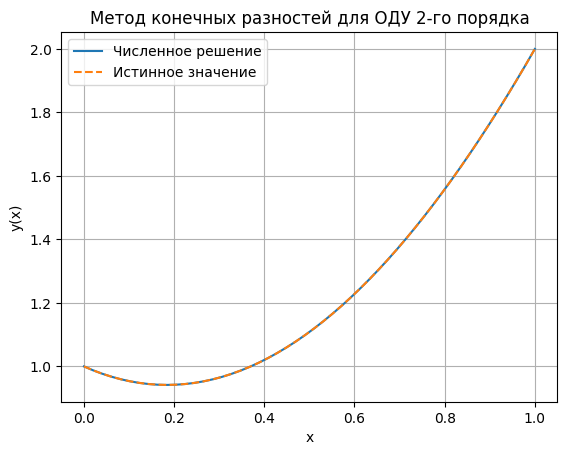

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Функции из уравнения
p = lambda x: x
q = lambda x: -2
f = lambda x: 2

# Граничные условия
a, b = 0, 1
ya, yb = 1, 2

# Количество узлов
n = 50
h = (b - a) / (n - 1)
x = np.linspace(a, b, n)

# Коэффициенты трехдиагональной системы
lower = np.zeros(n - 2)
main = np.zeros(n - 2)
upper = np.zeros(n - 2)
rhs = np.zeros(n - 2)

for i in range(1, n - 1):
    xi = x[i]

    # Разностные коэффициенты
    lower[i - 1] = 1 / h ** 2 - p(xi) / (2 * h)
    main[i - 1] = -2 / h ** 2 + q(xi)
    upper[i - 1] = 1 / h ** 2 + p(xi) / (2 * h)
    rhs[i - 1] = f(xi)

# Учет граничных условий
rhs[0] -= lower[0] * ya
rhs[-1] -= upper[-1] * yb


# Метод прогонки (метод Томаса)
def sweep_method(a, b, c, d):
    n = len(b)
    alpha = np.zeros(n)
    beta = np.zeros(n)

    alpha[0] = -c[0] / b[0]
    beta[0] = d[0] / b[0]

    for i in range(1, n - 1):
        denom = b[i] + a[i - 1] * alpha[i - 1]
        alpha[i] = -c[i] / denom
        beta[i] = (d[i] - a[i - 1] * beta[i - 1]) / denom

    y = np.zeros(n)
    y[-1] = (d[-1] - a[-1] * beta[-2]) / (b[-1] + a[-1] * alpha[-2])

    for i in range(n - 2, -1, -1):
        y[i] = alpha[i] * y[i + 1] + beta[i]

    return y


# Решение системы
y_inner = sweep_method(lower, main, upper, rhs)

# Полное решение
y = np.zeros(n)
y[0] = ya
y[-1] = yb
y[1:-1] = y_inner

# Вывод результатов
print("x       y(x)")
for i in range(n):
    print(f"{x[i]:.2f}   {y[i]:.6f}")

y_t = x ** 2

# Визуализация
plt.plot(x, y, label='Численное решение')
plt.plot(x, y, '--', label='Истинное значение')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Метод конечных разностей для ОДУ 2-го порядка')
plt.grid(True)
plt.legend()
plt.show()

## Le Chat

x		y
0.0000	0.0000
0.1000	0.0100
0.2000	0.0400
0.3000	0.0900
0.4000	0.1600
0.5000	0.2500
0.6000	0.3600
0.7000	0.4900
0.8000	0.6400
0.9000	0.8100
1.0000	1.0000


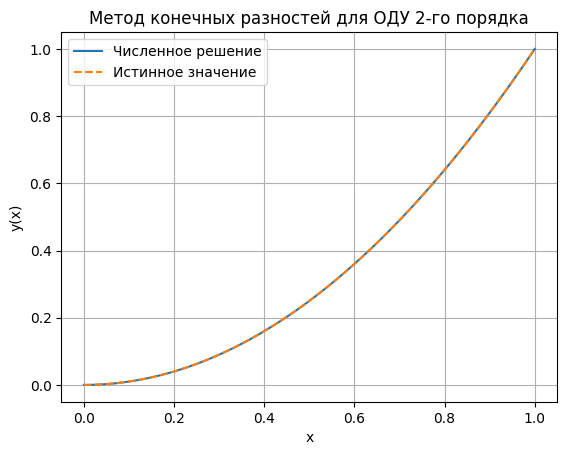

In [10]:
import numpy as np


def solve_boundary_value_problem(N):
    h = 1.0 / N
    y = np.zeros(N + 1)
    y[0] = 0  # y(0) = 0
    y[N] = 1  # y(1) = 1

    A = np.zeros((N - 1, N - 1))
    F = np.zeros(N - 1)

    for i in range(1, N):
        x_i = i * h
        A_i = 2 + h * x_i
        B_i = -4 - 4 * h ** 2
        C_i = 2 - h * x_i
        D_i = 4 * h ** 2

        if i == 1:
            A[i - 1, i - 1] = B_i
            A[i - 1, i] = A_i
            F[i - 1] = D_i
        elif i == N - 1:
            A[i - 1, i - 2] = C_i
            A[i - 1, i - 1] = B_i
            F[i - 1] = D_i - A_i * y[N]
        else:
            A[i - 1, i - 2] = C_i
            A[i - 1, i - 1] = B_i
            A[i - 1, i] = A_i
            F[i - 1] = D_i

    y_internal = np.linalg.solve(A, F)

    for i in range(1, N):
        y[i] = y_internal[i - 1]

    return y


# Пример использования
N = 100  # Количество интервалов
y = solve_boundary_value_problem(N)
x = np.linspace(0, 1, N + 1)

# Вывод некоторых значений
print("x\t\ty")
for i in range(0, N + 1, max(1, (N + 1) // 10)):
    print(f"{x[i]:.4f}\t{y[i]:.4f}")

y_t = x ** 2

plt.plot(x, y, label='Численное решение')
plt.plot(x, y_t, '--', label='Истинное значение')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Метод конечных разностей для ОДУ 2-го порядка')
plt.grid(True)
plt.legend()
plt.show()

## ChatGPT

In [ ]:
def thomas_algorithm(a, b, c, d):
    """
    Решение трёхдиагональной СЛАУ методом прогонки.
    a, b, c — диагонали (по длине n-1, n, n-1 соответственно)
    d — правая часть (длина n)
    Возвращает вектор x длины n.
    """
    n = len(b)
    # Прямой ход: модифицированные коэффициенты
    c_prime = np.zeros(n-1)
    d_prime = np.zeros(n)

    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]

    for i in range(1, n-1):
        denom = b[i] - a[i-1] * c_prime[i-1]
        c_prime[i] = c[i] / denom
        d_prime[i] = (d[i] - a[i-1] * d_prime[i-1]) / denom

    # последний элемент d_prime
    denom_last = b[n-1] - a[n-2] * c_prime[n-2]
    d_prime[n-1] = (d[n-1] - a[n-2] * d_prime[n-2]) / denom_last

    # Обратный ход: находим x
    x = np.zeros(n)
    x[-1] = d_prime[-1]
    for i in range(n-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i+1]

    return x

shape x = (11,)
shape d = (11,)
x = 0.000, y ≈ 0.000000
x = 0.100, y ≈ 0.009586
x = 0.200, y ≈ 0.039169
x = 0.300, y ≈ 0.088743
x = 0.400, y ≈ 0.158305
x = 0.500, y ≈ 0.247851
x = 0.600, y ≈ 0.357377
x = 0.700, y ≈ 0.486879
x = 0.800, y ≈ 0.636355
x = 0.900, y ≈ 0.805802
x = 1.000, y ≈ 1.000000


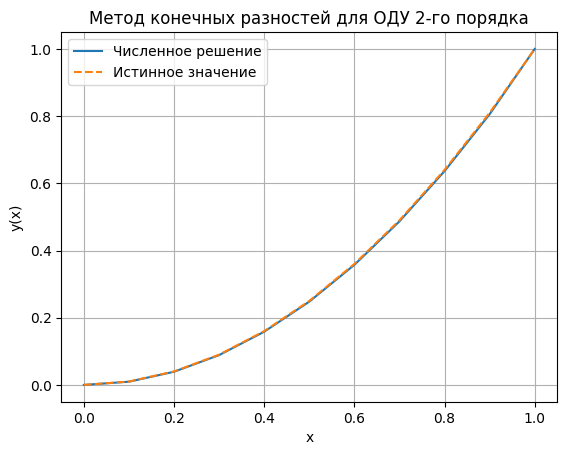

In [27]:
import numpy as np
from scipy.linalg import solve


def solve_dirichlet(p, q, f, lb=0.0, rb=1.0, N=10):
    # Сетка
    L = rb - lb
    h = L / N
    x = np.linspace(lb, rb, N + 1)

    # Матрица и правая часть
    A = np.zeros((N - 1, N - 1))
    a = np.zeros(N - 1)
    b = np.zeros(N - 1)
    c = np.zeros(N - 1)
    d = np.vectorize(f)(x)  # вектор d_i

    print(f'shape x = {x.shape}')
    print(f'shape d = {d.shape}')

    for i in range(1, N):
        xi = x[i]
        ai = 1 / h ** 2 - p(xi) / (2 * h)  # p(x)
        bi = -2 / h ** 2 + q(xi)  # q(x)
        ci = 1 / h ** 2 + p(xi) / (2 * h)  # p(x)

        j = i - 1  # индекс в матрице
        if j > 0:
            A[j, j - 1] = a
        A[j, j] = b
        if j < N - 2:
            A[j, j + 1] = c

        # учёт y_0=0, y_N=1:
        # на d[j] влияет c_1*y_0 для j=0 и a_{N-1}*y_N для j=N-2
        if j == 0:
            d[j + 1] -= a * lb
        if j == N - 2:
            d[j + 1] -= c * rb

    # Решаем СЛАУ
    y_inner = solve(A, d[1:N])

    # Собираем полный вектор y
    y = np.zeros(N + 1)
    y[0] = lb
    y[1:N] = y_inner
    y[N] = rb

    return x, y



p = lambda x: x
q = lambda x: -2
f = lambda x: 2
exact_fun = lambda x: x**2
lb = 0.0
rb = 1.0
N = 10  # число интервалов

x, y = solve_dirichlet(p, q, f, lb, rb, N)

# Выводим результаты
for xi, yi in zip(x, y):
    print(f"x = {xi:.3f}, y ≈ {yi:.6f}")

y_t = exact_fun(x)

plt.plot(x, y, label='Численное решение')
plt.plot(x, y_t, '--', label='Истинное значение')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Метод конечных разностей для ОДУ 2-го порядка')
plt.grid(True)
plt.legend()
plt.show()


## Deekpick

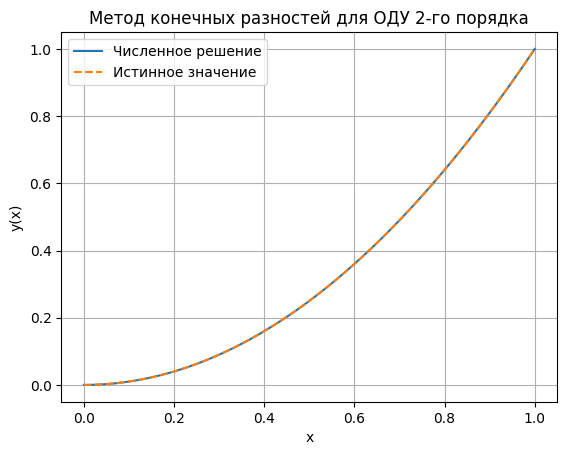

In [12]:
import numpy as np


def solve_finite_difference(N):
    h = 1.0 / N
    x = np.linspace(0, 1, N + 1)

    # Матрица системы (N-1 x N-1)
    A = np.zeros((N - 1, N - 1))
    F = np.zeros(N - 1)  # Правая часть

    for i in range(1, N):
        xi = x[i]
        ai = 1 - xi * h / 2
        bi = -2 - 2 * h ** 2
        ci = 1 + xi * h / 2

        # Заполняем строку матрицы
        if i - 1 > 0:
            A[i - 1, i - 2] = ai  # y_{i-1}
        A[i - 1, i - 1] = bi  # y_i
        if i < N - 1:
            A[i - 1, i] = ci  # y_{i+1}

        F[i - 1] = 2 * h ** 2

    # Учет граничных условий:
    F[0] -= (1 - x[1] * h / 2) * 0  # y0 = 0
    F[-1] -= (1 + x[N - 1] * h / 2) * 1  # yN = 1

    # Решение системы
    y_inner = np.linalg.solve(A, F)

    # Сборка полного решения
    y = np.zeros(N + 1)
    y[0] = 0
    y[1:N] = y_inner
    y[N] = 1

    return x, y


# Пример вызова
N = 100
x, y = solve_finite_difference(N)

y_t = x ** 2

plt.plot(x, y, label='Численное решение')
plt.plot(x, y_t, '--', label='Истинное значение')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Метод конечных разностей для ОДУ 2-го порядка')
plt.grid(True)
plt.legend()
plt.show()

## Main part

--- 1. Задача Дирихле ---
Решение методом конечных разностей (n=10):
[[0.         0.        ]
 [0.11111111 0.01234568]
 [0.22222222 0.04938272]
 [0.33333333 0.11111111]
 [0.44444444 0.19753086]
 [0.55555556 0.30864198]
 [0.66666667 0.44444444]
 [0.77777778 0.60493827]
 [0.88888889 0.79012346]
 [1.         1.        ]]

Точное решение:
[[0.         0.        ]
 [0.11111111 0.01234568]
 [0.22222222 0.04938272]
 [0.33333333 0.11111111]
 [0.44444444 0.19753086]
 [0.55555556 0.30864198]
 [0.66666667 0.44444444]
 [0.77777778 0.60493827]
 [0.88888889 0.79012346]
 [1.         1.        ]]

Максимальная абсолютная ошибка: 0.000000


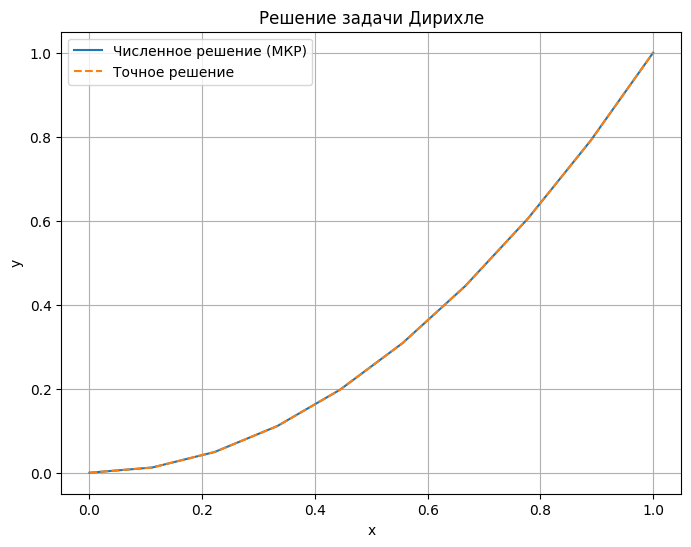

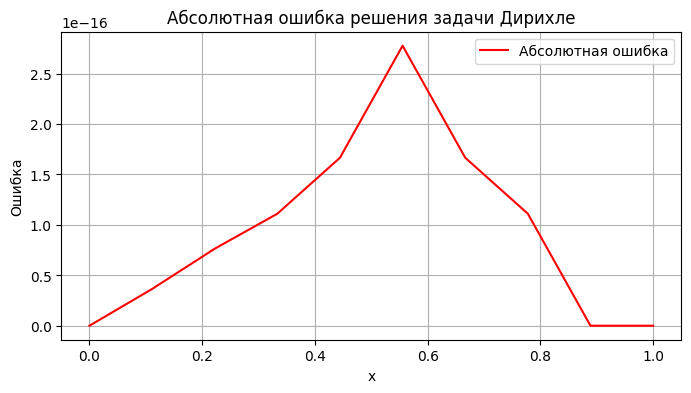


--- 2. Краевая задача методом конечных разностей ---

Решение методом конечных разностей (n=10):
[[0.6        0.49243195]
 [0.63333333 0.51576528]
 [0.66666667 0.53837578]
 [0.7        0.56039137]
 [0.73333333 0.58193527]
 [0.76666667 0.60312638]
 [0.8        0.62407954]
 [0.83333333 0.64490589]
 [0.86666667 0.6657132 ]
 [0.9        0.68660613]]

Решение методом конечных разностей (n=50):
[[0.6        0.49609676]
 [0.60612245 0.50038248]
 [0.6122449  0.50464102]
 [0.61836735 0.50887321]
 [0.6244898  0.51307986]
 [0.63061224 0.51726179]
 [0.63673469 0.52141978]
 [0.64285714 0.52555465]
 [0.64897959 0.52966717]
 [0.65510204 0.53375815]
 [0.66122449 0.53782835]
 [0.66734694 0.54187855]
 [0.67346939 0.54590953]
 [0.67959184 0.54992204]
 [0.68571429 0.55391685]
 [0.69183673 0.55789471]
 [0.69795918 0.56185637]
 [0.70408163 0.56580257]
 [0.71020408 0.56973406]
 [0.71632653 0.57365157]
 [0.72244898 0.57755582]
 [0.72857143 0.58144755]
 [0.73469388 0.58532748]
 [0.74081633 0.58919632]
 [0.746

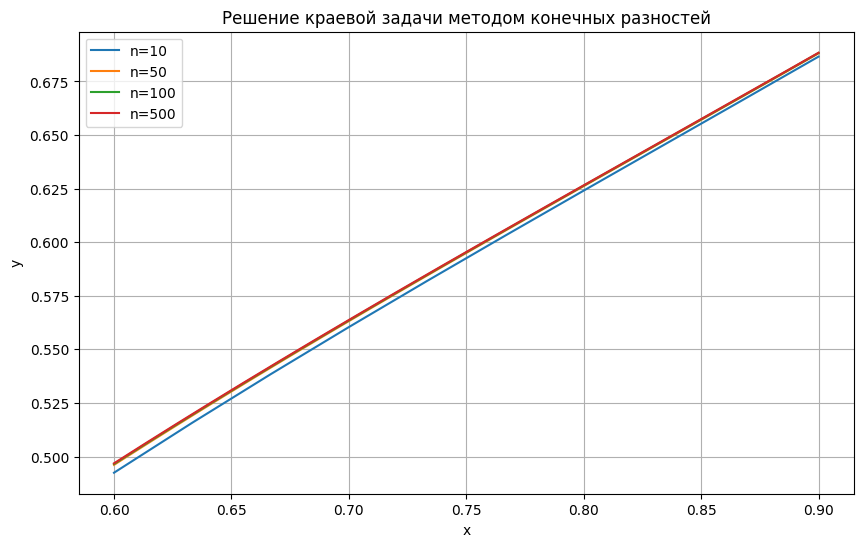


--- Анализ сходимости краевой задачи ---
Максимальная ошибка между n=50 и n=10: 0.003665
Максимальная ошибка между n=100 и n=50: 0.000406
Максимальная ошибка между n=500 и n=100: 0.000317

--- 3. Краевая задача - Строгий метод Галеркина (с подъемной функцией) ---
Подъемная функция: yp(x) = 0.72 + 0.7x
  - Проверка граничных условий для yp(x):
    yp'(0.6) = 0.700000 (требуется 0.7)
    yp(0.9) - 0.5*yp'(0.9) = 1.000000 (требуется 1)

Базисные функции для однородной задачи: psi0(x) = 0.57 - 1.2x + x^2 , psi1(x) = 0.918 - 1.08x + x^3
  - Проверка однородных граничных условий для psi0(x):
    psi0'(0.6) = 0.000000 (требуется 0)
    psi0(0.9) - 0.5*psi0'(0.9) = -0.000000 (требуется 0)
  - Проверка однородных граничных условий для psi1(x):
    psi1'(0.6) = 0.000000 (требуется 0)
    psi1(0.9) - 0.5*psi1'(0.9) = 0.000000 (требуется 0)

Коэффициенты Галеркина (c0, c1): [-1.06814365  0.50349083]
Приближенное решение методом Галеркина:
[[0.6        1.16038638]
 [0.60612245 1.16466614]
 [0.6122

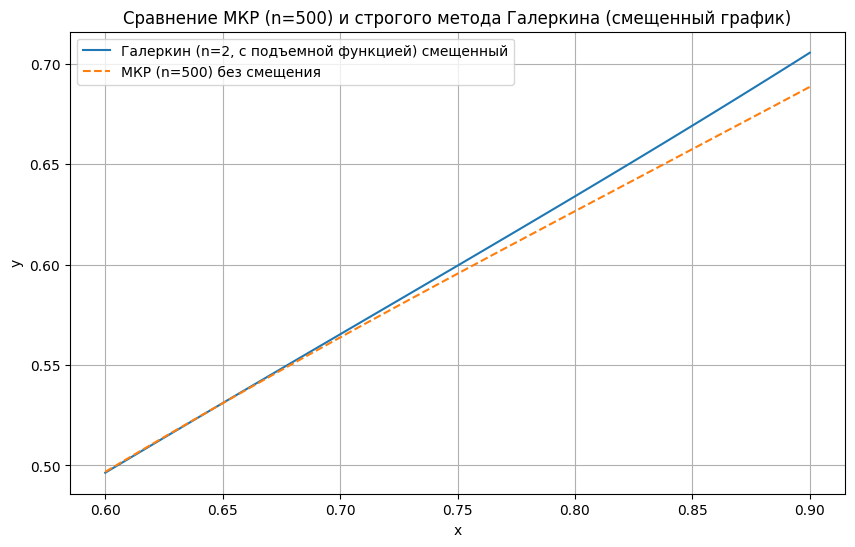

In [5]:
n_dirichlet = 10
x_dirichlet, y_fd_dirichlet = solve_dirichlet_fdm(n_dirichlet)
y_exact_dirichlet = x_dirichlet ** 2
error_dirichlet = np.abs(y_fd_dirichlet - y_exact_dirichlet)
max_error_dirichlet = np.max(error_dirichlet)

print("--- 1. Задача Дирихле ---")
print(f"Решение методом конечных разностей (n={n_dirichlet}):")
print(np.column_stack((x_dirichlet, y_fd_dirichlet)))
print("\nТочное решение:")
print(np.column_stack((x_dirichlet, y_exact_dirichlet)))
print(f"\nМаксимальная абсолютная ошибка: {max_error_dirichlet:.6f}")

plt.figure(figsize=(8, 6))
plt.plot(x_dirichlet, y_fd_dirichlet, label='Численное решение (МКР)')
plt.plot(x_dirichlet, y_exact_dirichlet, '--', label='Точное решение')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Решение задачи Дирихле')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(x_dirichlet, error_dirichlet, color='red', label='Абсолютная ошибка')
plt.xlabel('x')
plt.ylabel('Ошибка')
plt.title('Абсолютная ошибка решения задачи Дирихле')
plt.legend()
plt.grid(True)
plt.show()
# --- Краевая задача методом конечных разностей ---
n_boundary_list = [10, 50, 100, 500]  # Добавили 500 для МКР
solutions_boundary = {}

print("\n--- 2. Краевая задача методом конечных разностей ---")

plt.figure(figsize=(10, 6))
for n_boundary in n_boundary_list:
    x_boundary, y_fd_boundary = solve_boundary_fdm(n_boundary)
    solutions_boundary[n_boundary] = (x_boundary, y_fd_boundary)
    print(f"\nРешение методом конечных разностей (n={n_boundary}):")
    print(np.column_stack((x_boundary, y_fd_boundary)))
    plt.plot(x_boundary, y_fd_boundary, label=f'n={n_boundary}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Решение краевой задачи методом конечных разностей')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Анализ сходимости краевой задачи ---")
errors_boundary = {}
if len(solutions_boundary) >= 2:
    n_keys = sorted(solutions_boundary.keys())
    y_fine = None
    x_fine = None
    for i in range(len(n_keys)):
        n_coarse = n_keys[i]
        x_coarse, y_coarse = solutions_boundary[n_coarse]
        if y_fine is not None:
            y_coarse_interp = np.interp(x_fine, x_coarse, y_coarse)
            error = np.abs(y_fine - y_coarse_interp)
            max_error = np.max(error)
            errors_boundary[f'max_error(n={n_coarse}, n={n_fine})'] = max_error
            print(f"Максимальная ошибка между n={n_coarse} и n={n_fine}: {max_error:.6f}")
        n_fine = n_coarse
        x_fine, y_fine = solutions_boundary[n_fine]
else:
    print("Недостаточно решений для сравнения ошибок.")

# --- Краевая задача методом Галеркина (n=2) - СТРОГИЙ (с подъемной функцией) ---
x_galerkin_custom, y_galerkin_custom = solve_boundary_galerkin_strict_lifting()
